<center><img src="pictures/srgan/1.srgan_title.png" height=500; width=500><center>

<center>https://arxiv.org/pdf/1609.04802.pdf <center>
    link to the paper

<center>
    <h2>
        Generator 
    <h2>
<center>

In general, the work of the generator is to generate high resolution pictures that are indistinguishable from the real ones. And they don't only need to fool us, but to fool the discriminator, outputting such an image that the discriminator would simply recognize **real** but in fact it's the **generated** picture

<center><img src="pictures/srgan/generator_architecture.png"><center>

As we can see, the generator one *Low resolution* image, then it goes through number of operations which in the end "spits out" a image that is 256x256(2x bigger than the one we started with). </br>
So, the start of the model is like *Input* layer in Tensorflow, its' work is passing the image to the required size/channels to the blocks. </br>
The real fun starts here, 5 identical blocks are stacked one on top of the other. </br>
It consist of the following: </br>
- **Conv layer** - most common layer for working with images. It increases the channels and decreases the real image. And what are these x0 x1..? These are the feature maps with different weights and every time they go through the image some of the weights are changed, so the model is learning something. Here is a simple convolution taking place with a kernel size (3,3) and a stride of 1. <center><img src="https://media4.giphy.com/media/i4NjAwytgIRDW/giphy.gif?cid=ecf05e47xiq8ohgal1v0m6wq3p11cifyqjyo66jv6umne8wm&rid=giphy.gif&ct=g" height=200; width=200;></center>
</br>
</br>
</br>
- **Batch normalization** applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1. <center><img src="https://miro.medium.com/max/1400/1*DmnOhSTIzn04sC0w1d3FPg.webp" height=200; width=200;></center>
</br>
</br>
</br>
- **PReLU** - it is a variation of one of the most used activations in all Deep Learning - ReLU(Rectified Linear Unit) and the special thing about this particular variation of it that it depends on the number of input features. <center><img src="https://www.researchgate.net/publication/348106266/figure/fig7/AS:976144442593287@1609742379511/Leaky-ReLU-Parametric-ReLU-function-5.png" height=200; width=200;></center>
</br>
</br>
</br>
- **Elementwise Sum** - it's just a summation of two layers.
</br>
</br>
</br>

Next I'm going to continue with the second part of the generator.</br></br>
- **Pixelshuffle** is the new layer here. As it could be seen from the picture below, it takes many versions of the original image and then shuffles it so that it yields a high resolution picture. 
<center><img src="https://nico-curti.github.io/NumPyNet/NumPyNet/images/pixelshuffle.svg" height=400; width=400;></center>

<center>
    <h2>
        Discriminator
    <h2>
<center>

In a nutshell, the discriminator does what the name sugests, it discriminates. It gets fed both **real** and **generated** pictures. And its work is to take them, analyze them and then according to it, which picture is fake, which is not. Whenever the generator manages to fool the discriminator on multiple occasions, we could say that the **generated** are ~ **real**.

<center><img src="pictures/srgan/discriminator_block.png"><center>

The discriminator architecture is almost like the generator, but with a few differences. We have somewhat identical Input layer and then this is passed to a block of identical layers. After this, things are propagated to a Dense(Linear) layer with just one output with a sigmoid activaion function.
The layers I haven't looked at are the following: </br>
- **Leaky ReLU** - one more variation of the **ReLU** activation function. This variation uses a parameter α which determines the so called leak. So in a nutshell, more neurons can fire that way, because the activation function is not from 0 to ∞, but it's from 0.05(for example) to ∞. <center><img src="https://deeplearninguniversity.com/wp-content/uploads/2020/06/Screenshot-2020-06-04-at-9.13.01-PM.png" height=200; width=300;></center>
</br>
</br>
</br>
- **Linear** layer - the simplest layer that contains neurons(don't quote me on that). What it does is just linear transformation of the output. <center><img src="https://www.sharetechnote.com/image/Python_Pytorch_nn_Sequential_i1_H1_n4_H2_n6_o1_sigmoid_01.png" height=150; width=200;></center>
</br>
</br>
</br>
- **Sigmoid** layer - it's a layer that is often being used at the end of the algorithms where the output might be between 0 and 1. <center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1200px-Logistic-curve.svg.png" height=250; width=250;></center>


<center>
    <h4>
        The general architecture of the model
    <h4>
    <img src="https://camo.githubusercontent.com/1dbd924e022682ebf89bc760368941b849861c1386a0bce015df9dd41d85a702/68747470733a2f2f6c696c69616e77656e672e6769746875622e696f2f6c696c2d6c6f672f6173736574732f696d616765732f47414e2e706e67" height=400; width=400;>
<center>

In [1]:
def get_dataset():
  import json
  json_object = json.dumps({"username":"milenstanev","key":"b7cdda665e3939e2b406dc5ff07edb4f"})
  with open("kaggle.json", "w") as outfile:
    outfile.write(json_object)
  ! pip install -q kaggle
  ! mkdir ~/.kaggle 
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download -d joe1995/div2k-dataset
  !unzip div2k-dataset.zip;

In [2]:
get_dataset()

mkdir: cannot create directory ‘/home/h4rzor/.kaggle’: File exists
div2k-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  div2k-dataset.zip
replace DIV2K_train_HR/DIV2K_train_HR/0001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


We're going to start with the imports that will be needed to our notebook.

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim
from torchvision.datasets import Flickr8k
from torchvision.utils import save_image
import urllib
import torchvision.transforms
import torchvision
import torchvision.datasets 
from torchvision import transforms
from torchvision.transforms import transforms
import torchvision.models as models
from torchvision.models import vgg19
import PIL

/home/h4rzor/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

**So, this is the discriminator block, the main part of the discriminator architecture. It's being called from the Discriminator class later.** 
<center><img src="pictures/srgan/discriminator_block.png" height=100; width=100;><center>


In [5]:
class Discriminator_block(nn.Module):
    def __init__(self,in_channels, out_channels, batch_norm, stride):
        super(Discriminator_block, self).__init__()
        
        self.cnn = nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), stride=stride, padding=1)
        #As it could be seen from the pictures above, we initialize Conv2d layer with the hyperparameters
        # that are contained in the paper(at least I hope I could be as accurate as the paper).
        
        self.batch_norm_layer = nn.BatchNorm2d(out_channels) if batch_norm is True else nn.Identity()
        #If batch_norm is False we have this nn.Identity() layer. It's very simple, the information flow
        # from the layer before Identity goes to the layer after Identity, in other words, it's like a 
        # skip connection.
        
        self.activation = nn.LeakyReLU(0.2)
        #Initializing the activation
        
        self.batch_norm = batch_norm
    
    def forward(self, x):
        if self.batch_norm is True:
            #If we have batch_norm set to True, we use it, if not, we use Identity
            return self.activation(self.batch_norm_layer(self.cnn(x)))
        return self.activation(self.batch_norm_layer(self.cnn(x)))

In [6]:
class Discriminator(nn.Module):
    def __init__(self,out_channels,in_channels=3,features=[64,64,128,128,256,256,512,512]):
        super(Discriminator, self).__init__()
        
        self.layers = [] #Initializing the block layers
        for i, channels in enumerate(features):#the features(channels) are present as input parameter
            if i == 0:#The first layer does not use batch_norm
                self.layers.append(Discriminator_block(in_channels, channels, batch_norm=False, stride=1 + i % 2))
                #We append the layers to the list with these parameters. One note, the stride is either 
                # 1 or 2, that's why it's the way it is 
            else:
                self.layers.append(Discriminator_block(in_channels, channels, batch_norm=True, stride = 1 + i % 2))
            in_channels = channels
            #Very important line, with every passage of a Conv2d layer over the image, its channels grow

        self.disc = nn.Sequential(*self.layers)
        #We spread the layers that we've acquired from the for cycle into a Sequential model. In other words
        # the input of the N block comes from the N - 1 block.
        
        
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6,6)),#It's like convolution with a given kernel size, it gets the avg of 6x6 kernel and outputs 1 number
            nn.Flatten(),#If we for example have 32x32 image, if we apply this layer we would end up with a tensor with shape [1024]
            nn.Linear(512*6*6, 1024),#Following the paper, it's with 1024 neurons in the second to last linear.
            nn.LeakyReLU(0.2),#Applying activation
            nn.Linear(1024,1),#The final layer of the model, it's 1 because the output should be between 0 and 1
        )
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):#x in this case is an image, which is being propagated through the model
        out = self.disc(x)
        out = self.classifier(out)
        return self.sigmoid(out)#Applying sigmoid activaiton function on the output(1) of the discriminator

**What's next is the generator block. It is the backbone of the generator architecture.** <center><img src="pictures/srgan/generator_block.png" height=200; width=200;><center>

In [7]:
class Generator_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator_block, self).__init__()

        self.cnn = nn.Conv2d(64, 64, kernel_size=(3,3), stride=1, padding=1)
        self.batch_norm_layer = nn.BatchNorm2d(64)
        self.prelu = nn.PReLU(num_parameters=64)
        self.cnn2 = nn.Conv2d(64, 64, kernel_size=(3,3), stride=1, padding=1)
        self.batch_norm_layer2 = nn.BatchNorm2d(64)
        self.prelu2 = nn.PReLU(num_parameters=64)
        
        #Simple initialization of the layers


    def forward(self, x):#x is a low resolution image
        out = self.cnn(x)
        out = self.batch_norm_layer(out)
        out = self.prelu(out)
        out = self.cnn2(out)
        out = self.batch_norm_layer2(out)
        out = self.prelu2(out)
        
        #Passing through the different layers
        return out + x #Skip connection

**This is the upsample block of the generator** <center><img src="pictures/srgan/upsample_block.png" height=100; width=100;><center>

In [8]:
class Generator_block_upsample(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super(Generator_block_upsample, self).__init__()

        self.cnn = nn.Conv2d(in_channels, in_channels * scale_factor ** 2, 3, 1, 1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)#Initializing the thing that upscales images.
        self.prelu = nn.PReLU()

    def forward(self, x):#x is low resolution image
        out = self.prelu(self.pixel_shuffle(self.cnn(x)))
        return out

**This is the whole generator structure combined. A picture of it could be seen at the top of the project.**

In [9]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()

        self.first_cnn = nn.Conv2d(in_channels, out_channels, kernel_size=(9,9), stride=1, padding=4)
        self.first_prelu = nn.PReLU()
        #The first two layers

        self.layers = []
        for i in range(5):
            self.layers.append(Generator_block(in_channels, out_channels))
        #Creating the blocks that will be needed afterwards.


        self.second_cnn = nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), stride=1, padding=1)
        self.batch_norm_layer = nn.BatchNorm2d(64)
        #Intermediate layers initialization

        self.upsample = []
        for i in range(1):
            self.upsample.append(Generator_block_upsample(64, 2))
        #I know that the layers here are supposed to be 2, but I messed it up so many times, that
        # I just left it this way.
        
        self.last_cnn = nn.Conv2d(out_channels, in_channels, kernel_size=9, stride=1, padding=4)

        self.main_layers = nn.Sequential(*self.layers)#Spreading the main block layers
        self.upsample_layers = nn.Sequential(*self.upsample)#Spreading the upsample layers

    def forward(self, x):#x is low resolution image
        first_layer = self.first_cnn(x)
        out = self.first_prelu(first_layer)
        out = self.main_layers(out)
        out = out + first_layer#Skip connections
        out = self.second_cnn(out)
        out = self.batch_norm_layer(out)
        out = out + first_layer#Skip connections
        out = self.upsample_layers(out)
        out = self.last_cnn(out)
        out = torch.tanh(out)   
        return out

**This right here is VGG19 model. I'm using it to compare the generated and the target image.**

<center><img src="pictures/srgan/vgg_19.png" height=250; width=250;><center>

In [10]:
class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:36].eval().to(DEVICE)
        self.loss = nn.MSELoss()

        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        vgg_input_features = self.vgg(input)
        vgg_target_features = self.vgg(target)
        return self.loss(vgg_input_features, vgg_target_features)

In [11]:
highres_transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x * 2) - 1)
    ]
)
lowres_transform = transforms.Compose(
    [
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x * 2) - 1)
    ]
)
#Making the image between -1 and 1, resizing and casting to tensor

**With the models ready, we could begin creating the datasets. The dataset consists of 800 low resolution and 800 high resolution images**

In [12]:
class ImageFolder(Dataset):#We're using the inherited Dataset class from torch to make things easier
    def __init__(self, root_dir="DIV2K_train_HR/DIV2K_train_HR/"):
        super(ImageFolder, self).__init__()
        self.data = []
        self.root_dir = root_dir
        self.class_names = os.listdir(root_dir)#low and high

        for index, name in enumerate(self.class_names):
            files = os.listdir(os.path.join(root_dir))#Lists all the files within that directory
            self.data = list(zip(files, [index] * len(files)))#Appends the images as lists to the data variable

    def __len__(self):#When we begin iterating through the data, this is what is returned
        return len(self.data)#returns the length of the data variable

    def __getitem__(self, index):#When we ask for a batch or a sample this method is invoked
        img_file, label = self.data[index]#Gets the picture from data at this index
        root_and_dir = os.path.join(self.root_dir, self.class_names[label])#Gets the root dir and number of image
        image = Image.open(os.path.join("DIV2K_train_HR/DIV2K_train_HR", img_file))#The image
        
        high_res = highres_transform(image)#Transforming the high res image
        
        low_res = lowres_transform(image)#Transforming the low res image
        
        return low_res, high_res

In [13]:
dataset = ImageFolder()#Making the ImageFolder
train_loader = torch.utils.data.DataLoader(dataset=dataset,
                                               batch_size=1, 
                                               shuffle=False)
#The dataloader is a handy class which helps us to prepare, change and overall wrangle with the data inside of it.
tensor_to_image = transforms.Compose([
        transforms.Lambda(lambda x: (x + 1) / 2),
        transforms.Lambda(lambda x: x.permute(1,2,0)),
        transforms.Lambda(lambda x: x * 255),
        transforms.Lambda(lambda x: x.numpy().astype(np.uint8)),
        transforms.ToPILImage()])
#Transforming the pictures and keeping the colors the same(very important, otherwise I've seen a blue lion)

In [14]:
NUM_EPOCHS = 20 #The times that the model goes through the dataset
BATCH_SIZE = 1 #I know it's low, but it's in the paper

In [15]:
LEARNING_RATE = 0.0002

<img src="https://dmol.pub/_images/loss-lr.gif" height=500; width=500;>

In [16]:
gen = Generator(3, 64).to(DEVICE)  #Instantiating the generator and making it go on the gpu
disc = Discriminator(64).to(DEVICE)##Instantiating the discriminator and making it go on the gpu

In [17]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999)) 
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))

#We initialize optimizers for each of the models. We give them the individual parameters of the model,
# the learning rate and something called betas or weight decay - our weights are multiplied with a small number
# β1 and β2 in order to help the model generalize better.

**This is a very simplified version of what is happening. Although simple, this version has a lot in common with the training process of our SRGAN, it has input, it has deep layers and it has an output. It may be different, but the underlying logic is the same** <center><img src="https://thumbs.gfycat.com/AnguishedPastAidi-max-1mb.gif" height=400; width=400;><center>

**There are two main components of this algorithm(training algorithm) - forward propagation and backward propagation.**
- **The forward propagation is a process of giving the model inputs, it forward propagates this input, it's applying different transformation to the input(linear layer, convolution layer, dropout layer) and in the end it give us some output that is being juxtaposed to the real target label. This way we could calculate how wrong the model is and how we could penalize or not penalize it.** <center><img src="https://yogayu.github.io/DeepLearningCourse/03/video/layer.gif" height=350; width=350><center>

**The second thing is what I think is really the most important thing in deep learning. That is backward propagation.**
- **The backward propagation is the process of backward propagating through the network and changing the models' weights and biases(learnable parameters) in order to reduce the loss between the models' output and the target label. We've calculated the loss. The loss is high. We have to make some changes to the models' weights and biases. We do it pretty easy with Torch and Tensorflow, which prevent us to do this step manually. They take care of the huge amount of maths that is being done on low level. We do this for N amount of cycles, until the loss couldn't go any lower. If the loss couldn't go any lower, we are sure that we are left with the best weights and biases of the model that we possibly could.** <center><img src="https://thumbs.gfycat.com/EquatorialSpicyEgg-max-1mb.gif" height=450; width=450><center>

In [18]:
def plot_images(low_res, high_res, fake):
    low_res = low_res.detach().cpu()#Sending picture to cpu()
    low_res = low_res.squeeze(dim=0)#Removing the batch from the image
    low_res = tensor_to_image(low_res)#Applying transormations
    plt.imshow(low_res)
    plt.show()

    high_res = high_res.detach().cpu()#Sending picture to cpu()
    high_res = high_res.squeeze(dim=0)#Removing the batch from the image
    high_res = tensor_to_image(high_res)#Applying transormations
    plt.imshow(high_res)
    plt.show()

    fake = fake.detach().cpu()#Sending picture to cpu()
    fake = fake.squeeze(dim=0)#Removing the batch from the image
    fake = tensor_to_image(fake)#Applying transormations
    plt.imshow(fake)
    plt.show()

**This is the most important part of the whole architecture. It is the training function. All of the weights and biases are updated here.**
- **Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.** </br>

- **In a nutshell, this is the whole formula for the GAN architecture** </br>
$\min_{\theta_{G}}\max_{\theta_{D}}\mathbb{E}_{I^{HR}
\sim p_{train}(I^{HR})}[log D_{{\theta}_{D}}(I^{HR})] + 
\mathbb{E}_{I^{LR} \sim p_G(I^{LR})}[log(1 - D_{{\theta}_{D}}(G_{{\theta}_{G}}(I^{LR}))]$ </br>
- **The generator tries to minimize the loss, whereas the discriminator tries to maximize it, thus creating the interesting part of this architecture, two models are fighting with each other in order to get better at the thing they do. As the generator improves with training, the discriminator performance gets worse because the discriminator can't easily tell the difference between real and fake. If the generator succeeds perfectly, then the discriminator has a 50% accuracy. In effect, the discriminator flips a coin to make its prediction.**

Our ultimate goal is to train a generating function G that
estimates for a given LR input image its corresponding HR
counterpart. To achieve this, we train a generator network as
a feed-forward CNN $G_{{\theta}_{G}}$ parametrized by $\theta_{G}.$ Here $\theta_{G} = \{W_{1:L};b_{1:L}\}$ denotes the weights and biases of a L-layer deep network and is obtained by optimizing a SR-specific loss function $l^{SR}$. For training images $I_{n}^{HR}, n = 1,....,N$ with corresponding $I_{n}^{LR}, n = 1,....,N, $ we solve: $\hat\theta = arg \ \min_{\theta_{G}} \frac{1}{N} \sum_{n=1}^{N} l^{SR}(G_{{\theta}_{G}}(I_{n}^{LR}),I_{n}^{HR})$ </br>

The general idea behind this formulation is that it allows
one to train a generative model $G$ with the goal of fooling a
differentiable discriminator $D$ that is trained to distinguish
super-resolved images from real images. With this approach
our generator can learn to create solutions that are highly
similar to real images and thus difficult to classify by D.

We define the VGG loss based on the ReLU activation layers of the pre-trained 19 layer VGG network described in Simonyan and Zisserma: $
l^{SR} = l_{x}^{SR} + 10^{-3} l_{gen}^{SR}
$ 

The formula that they are using is as follows: </br>

$l_{VGG/{i,j}}^{SR} = \frac{1}{W_{i,j}H{i,j}}\sum_{x=1}^{W_{i,j}}\sum_{y=1}^{H_{i,j}}(\phi_{i,j}(I^{HR})x,y-\phi_{i,j}(G_{{\theta}_{G}}(I^{HR}))x,y) ^ 2$ </br>

Here $W_{i,j}$ and $H_{i,j}$ describe the dimensions of the respective feature maps within the VGG network

In addition to the content losses described so far, we also
add the generative component of our GAN to the perceptual
loss. The generative loss $l_{Gen}^{SR}$ is defined based on the probabilities of the discriminator $D_{{\theta}_{D}}(G_{{\theta}_{G}}(I^LR))$ over all training samples as: $l_{Gen}^{SR} = \sum_{n=1}^{N} - log D_{{\theta}_{D}}(G_{{\theta}_{G}}(I^{LR}))$ $\text{   }$Here, $D_{{\theta}_{D}}(G_{{\theta}_{G}}(I^{LR}))$ is the probability that the reconstructed image $G_{{\theta}_{G}}(I^{LR})$ is a natural HR image. For better gradient behavior we minimize $-log D_{{\theta}_{D}}(G_{{\theta}_{G}}(I^{LR}))$ instead of $log[1 - D_{{\theta}_{D}}(G_{{\theta}_{G}}(I^{LR}))]$ </br>
They named this loss adversarial loss.

In [25]:
mse = nn.MSELoss() #This is the loss used for comparing the both pictures

In [26]:
vgg_loss = VGGLoss()#Instantiating the vgg_loss

In [27]:
bce = nn.BCEWithLogitsLoss()#More stable loss as it says in the documentation

In [32]:
def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, vgg_loss, bce):#Passing the required parameters to the function
    for epoch in range(NUM_EPOCHS):
        loop = tqdm(loader, leave=True)

        for idx, (low_res, high_res) in enumerate(loop):
            high_res = high_res.to(DEVICE)#Sending the pictures to gpu
            low_res = low_res.to(DEVICE)#Sending the picture to gpu

            fake = gen(low_res)#Generating the fake image
            disc_real = disc(high_res)
            #Making the discriminator to decide whether the real image is 
            # fake or not


            disc_fake = disc(fake.detach())
            #Making the discriminator to decide whether the fake image is 
            # fake or not

            disc_loss_real = bce(
                disc_real, torch.ones_like(disc_real) - 0.1 * torch.rand_like(disc_real)
            )
            #We want to compare the real high resolution with the highest 
            # possibility that this image is real i.e. 1

            disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
            #We want to compaer the fake output with the lowest possibility
            # that this image is real i.e. 0

            loss_disc = disc_loss_fake + disc_loss_real
            #Combining the two losses

            opt_disc.zero_grad()#Zeroing out the gradients
            loss_disc.backward()#Computes the gradient of the current tensor - opt_disc
            opt_disc.step()#The simple way to do backward propagation, optimizer changes weights and biases here(learning)

            disc_fake = disc(fake)
            #Again passing the fake image through the discriminator

            adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
            #The adversarial equation from the cell above


            loss_for_vgg = 0.006 * vgg_loss(fake, high_res)
            #Passing the image throught the vgg network and getting the MSE error

            gen_loss = loss_for_vgg + adversarial_loss
            #Combining the two losses

            opt_gen.zero_grad()#Zeroing out the gradients
            gen_loss.backward()#Computes the gradient of the current tensor - gen_loss
            opt_gen.step()#The simple way to do backward propagation, optimizer changes weights and biases here(learning)

            if epoch == 19: 
                plot_images(low_res, high_res, fake)
                return ""
                #This is just a helper function to visualize the images
                #Plotting it this way because of github's size limit of notebooks.
       

  0%|                                                   | 0/800 [00:00<?, ?it/s]

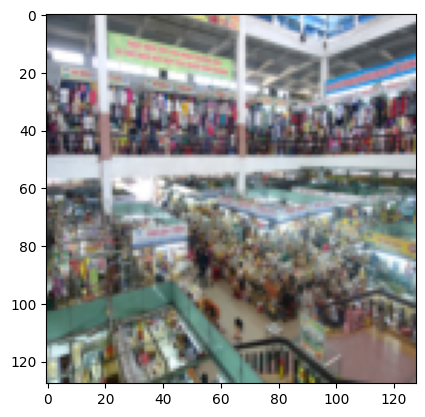

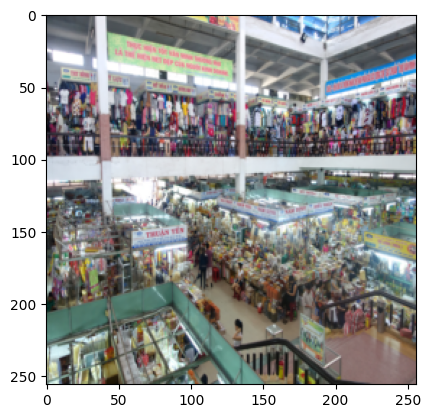

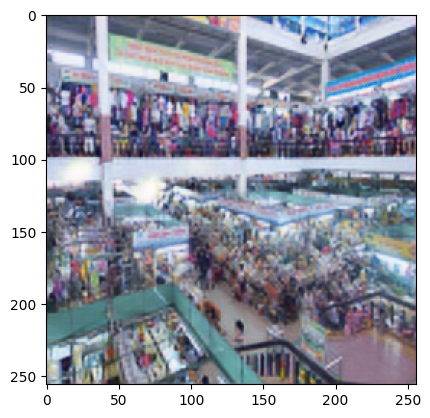

  0%|                                                   | 0/800 [00:00<?, ?it/s]


''

In [33]:
train_fn(train_loader, disc, gen, opt_gen, opt_disc, mse, vgg_loss, bce)

In [34]:
def predict_image_srgan():
    low,high = dataset.__getitem__(25)#Getting the images from the dataset
    low = low.to(device)#Sending it to the gpu
    low = torch.unsqueeze(low, dim=0)#Increasing the dimensionality of the image at dim 0
    gen.eval()#Turning generator to evaluation mode
    result = gen(low)#Generating new image
    
    plot_images(low, high, result)
    
    return result

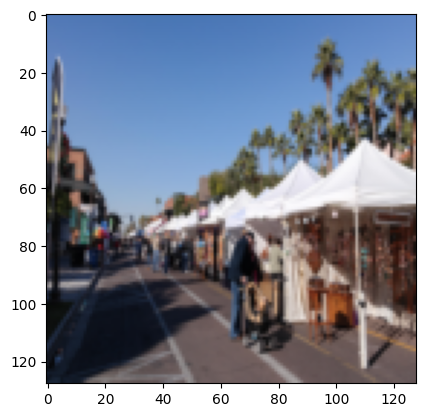

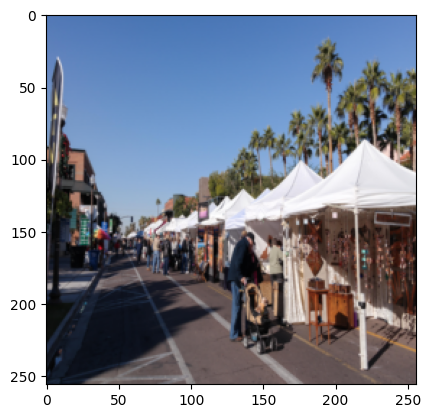

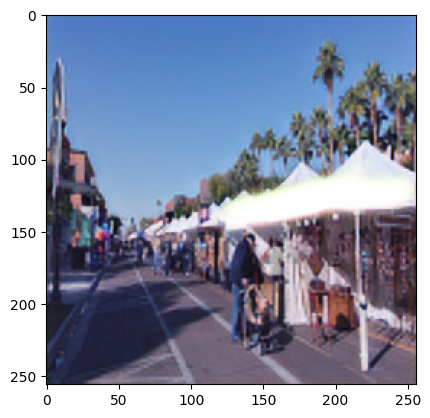

torch.Size([1, 3, 256, 256])

In [35]:
predicted_srgan = predict_image_srgan()#Executing the upper cell
predicted_srgan.shape